# E09. 영화리뷰 텍스트 감정 분석하기

In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# 9-11. Naver 영화리뷰 감성분석 도전하기
---
- 데이터셋: [Naver sentiment movie corpus](https://github.com/e9t/nsmc)
- 아래와 같이 다운로드
```sh
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt
$ wget https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt
$ mv ratings_*.txt ~/aiffel/e/e09_sentimental_classification
```

## 1) 데이터 준비와 확인

In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/e/e09_sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/e/e09_sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
train_data.shape

(150000, 3)

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


## 2) 데이터로더 구성
실습때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [5]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [6]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [7]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

3) 모델구성을 위한 데이터 분석 및 가공
---
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [8]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

# maxlen = 41

문장길이 평균 :  15.96938143432699
문장길이 최대 :  116
문장길이 표준편차 :  12.843571939469296
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [9]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


4) 모델구성 및 validation set 구성
---
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

### valid set 구성

In [10]:
# valid set 30000건 분리 -> 했다가 커널 리셋해도 valid accuracy가 0.8대부터 시작해서
# valid set 10000건으로 바꿈
x_val = X_train[:10000]   
y_val = y_train[:10000]

# 나머지 116182건
partial_x_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [11]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

### 모델 1 - multi layer LSTM

In [12]:
model_lstm_sl = keras.Sequential(name="LSTM_single_layer")
model_lstm_sl.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm_sl.add(keras.layers.LSTM(8)) # 바꿀 수 있음
model_lstm_sl.add(keras.layers.Dense(16, activation="relu"))
model_lstm_sl.add(keras.layers.Dense(1, activation="sigmoid"))

model_lstm_sl.summary()

Model: "LSTM_single_layer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 16)                144       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,961
Trainable params: 160,961
Non-trainable params: 0
_________________________________________________________________


### 모델 2 : multi layer lstm

In [13]:
model_lstm_ml = keras.Sequential(name="stacked_LSTM")
model_lstm_ml.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm_ml.add(keras.layers.LSTM(64, return_sequences = True)) # 바꿀 수 있음
model_lstm_ml.add(keras.layers.LSTM(32, return_sequences = False)) # 바꿀 수 있음
model_lstm_ml.add(keras.layers.Dense(16, activation="relu"))
model_lstm_ml.add(keras.layers.Dense(1, activation="sigmoid"))

model_lstm_ml.summary()

Model: "stacked_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          20736     
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 193,697
Trainable params: 193,697
Non-trainable params: 0
_________________________________________________________________


### 모델 3 : cnn


In [14]:
model_cnn = keras.Sequential(name="CNN")
model_cnn.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_cnn.add(keras.layers.Conv1D(128, 7, activation="relu"))
model_cnn.add(keras.layers.MaxPooling1D(5))
model_cnn.add(keras.layers.Conv1D(64, 7, activation="relu"))
model_cnn.add(keras.layers.GlobalMaxPooling1D())
model_cnn.add(keras.layers.Dense(16, activation="relu"))
model_cnn.add(keras.layers.Dense(1, activation="sigmoid"))

model_cnn.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         14464     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 64)          57408     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17      

5) 모델 훈련 개시
---

모델
- model_lstm_single layer
- model_stacked_layer
- model_cnn

model 학습 시작

In [15]:
# model_lstm_sl
model_lstm_sl.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=16  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm_sl = model_lstm_sl.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/16
266/266 [==============================] - 1s 6ms/step - loss: 0.5223 - accuracy: 0.7223 - val_loss: 0.3602 - val_accuracy: 0.8470
Epoch 2/16
266/266 [==============================] - 1s 4ms/step - loss: 0.3406 - accuracy: 0.8554 - val_loss: 0.3429 - val_accuracy: 0.8532
Epoch 3/16
266/266 [==============================] - 1s 4ms/step - loss: 0.3206 - accuracy: 0.8657 - val_loss: 0.3471 - val_accuracy: 0.8470
Epoch 4/16
266/266 [==============================] - 1s 4ms/step - loss: 0.3101 - accuracy: 0.8693 - val_loss: 0.3412 - val_accuracy: 0.8507
Epoch 5/16
266/266 [==============================] - 1s 5ms/step - loss: 0.3009 - accuracy: 0.8732 - val_loss: 0.3434 - val_accuracy: 0.8507
Epoch 6/16
266/266 [==============================] - 1s 5ms/step - loss: 0.2937 - accuracy: 0.8756 - val_loss: 0.3479 - val_accuracy: 0.8504
Epoch 7/16
266/266 [==============================] - 1s 4ms/step - loss: 0.2863 - accuracy: 0.8776 - val_loss: 0.3595 - val_accuracy: 0.8462
Epoch 

In [16]:
# model_lstm_ml
model_lstm_ml.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=16  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_lstm_ml = model_lstm_sl.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/16
266/266 [==============================] - 1s 5ms/step - loss: 0.2300 - accuracy: 0.8969 - val_loss: 0.4220 - val_accuracy: 0.8369
Epoch 2/16
266/266 [==============================] - 1s 5ms/step - loss: 0.2260 - accuracy: 0.8987 - val_loss: 0.4402 - val_accuracy: 0.8354
Epoch 3/16
266/266 [==============================] - 1s 4ms/step - loss: 0.2224 - accuracy: 0.9000 - val_loss: 0.4485 - val_accuracy: 0.8360
Epoch 4/16
266/266 [==============================] - 1s 4ms/step - loss: 0.2186 - accuracy: 0.9014 - val_loss: 0.4623 - val_accuracy: 0.8400
Epoch 5/16
266/266 [==============================] - 1s 4ms/step - loss: 0.2160 - accuracy: 0.9026 - val_loss: 0.4541 - val_accuracy: 0.8362
Epoch 6/16
266/266 [==============================] - 1s 4ms/step - loss: 0.2133 - accuracy: 0.9046 - val_loss: 0.4662 - val_accuracy: 0.8369
Epoch 7/16
266/266 [==============================] - 1s 4ms/step - loss: 0.2098 - accuracy: 0.9057 - val_loss: 0.4609 - val_accuracy: 0.8376
Epoch 

In [17]:
# model_cnn
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=16  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_cnn = model_cnn.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/16
266/266 [==============================] - 6s 21ms/step - loss: 0.4354 - accuracy: 0.7875 - val_loss: 0.3388 - val_accuracy: 0.8517
Epoch 2/16
266/266 [==============================] - 1s 5ms/step - loss: 0.3155 - accuracy: 0.8649 - val_loss: 0.3307 - val_accuracy: 0.8533
Epoch 3/16
266/266 [==============================] - 1s 6ms/step - loss: 0.2815 - accuracy: 0.8824 - val_loss: 0.3294 - val_accuracy: 0.8557
Epoch 4/16
266/266 [==============================] - 1s 6ms/step - loss: 0.2477 - accuracy: 0.8998 - val_loss: 0.3407 - val_accuracy: 0.8547
Epoch 5/16
266/266 [==============================] - 1s 6ms/step - loss: 0.2115 - accuracy: 0.9169 - val_loss: 0.3646 - val_accuracy: 0.8575
Epoch 6/16
266/266 [==============================] - 1s 5ms/step - loss: 0.1739 - accuracy: 0.9351 - val_loss: 0.4005 - val_accuracy: 0.8486
Epoch 7/16
266/266 [==============================] - 1s 5ms/step - loss: 0.1404 - accuracy: 0.9497 - val_loss: 0.4600 - val_accuracy: 0.8468
Epoch

### 모델 평가

In [18]:
results = model_lstm_sl.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5266 - accuracy: 0.8274
[0.5265513062477112, 0.8274101614952087]


In [19]:
results = model_lstm_ml.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.6933 - accuracy: 0.4933
[0.6933446526527405, 0.4932969808578491]


In [20]:
results = model_cnn.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.9680 - accuracy: 0.8243
[0.9680478572845459, 0.824256956577301]


6) Loss, Accuracy 그래프 시각화
---

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


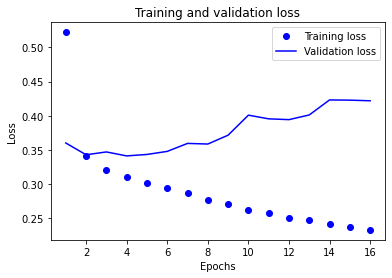

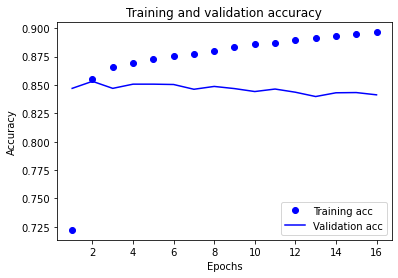

In [21]:
# model 1 viz
history_dict = history_lstm_sl.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# accuracy graph
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


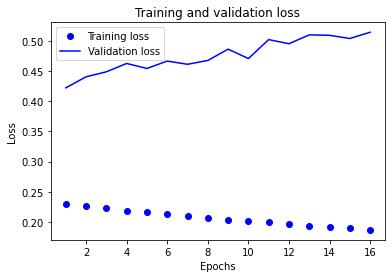

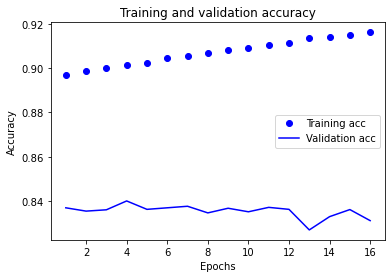

In [22]:
# model 2 viz
history_dict = history_lstm_ml.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# accuracy graph
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


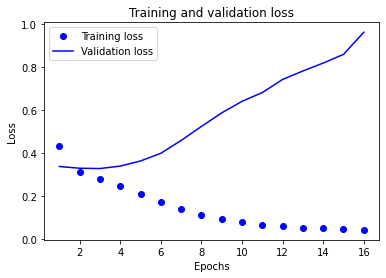

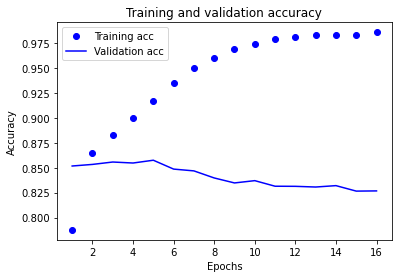

In [23]:
# model 3 viz
history_dict = history_cnn.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# accuracy graph
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

train할 때 valication accuracy는 원인 불명의 이유로 epoch 1부터 굉장히 높게 나타났으나, 최종 evaluation과 loss/accuracy 시각화에서 볼 수 있듯 엄청난 과적합을 보이고 있다.

7) 학습된 Embedding 레이어 분석
---

In [26]:
embedding_layer_sl = model_lstm_sl.layers[0]
weights = embedding_layer_sl.get_weights()[0]
print(weights.shape)

(10000, 16)


In [31]:

import os

# 학습한 Embedding 파라미터를 파일에 써서 저장
word2vec_file_path = os.getenv('HOME')+'/aiffel/e/e09_sentiment_classification/word2vec_mdl.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록
vectors = model_lstm_sl.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [41]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['비추']

In [43]:
word_vectors.similar_by_word("비추")

[('진출', 0.9831271171569824),
 ('.-_-', 0.9774754047393799),
 ('요란', 0.9741014242172241),
 ('지진희', 0.9737154841423035),
 ('별로', 0.9736986756324768),
 ('삼류', 0.972091555595398),
 ('쎄', 0.9711558818817139),
 ('광주', 0.9708691835403442),
 ('고은', 0.9706121683120728),
 ('마감', 0.9701137542724609)]

요란, 별로, 삼류, 쎄, -_- 의 경우 비추와 어느정도 일백상통하는 부분이 있으나, 나머지 반 절 정도는 크게 연관성이 없는 단어들이 나온다.

8) 한국어 Word2Vec 임베딩 활용하여 성능개선
---
한국어 Word2Vec은 다음 경로에서 구할 수 있습니다.

[https://github.com/Kyubyong/wordvectors](https://github.com/Kyubyong/wordvectors)

In [68]:
import os
from gensim.models import Word2Vec
word2vec_path = os.getenv('HOME')+'/aiffel/e/e09_sentiment_classification/ko.bin'
word2vec = Word2Vec.load(word2vec_path)


In [69]:
vector = word2vec['비추']
vector

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-1.2688204e+00,  7.2831303e-02,  1.5410466e+00, -2.5209320e+00,
       -2.2645350e+00, -1.5054817e+00, -7.3957473e-01, -1.0565723e+00,
       -2.5180078e-01,  5.4651266e-01, -5.5514979e-01,  1.2088622e+00,
       -4.7946307e-01,  1.0605360e+00,  9.5630324e-01,  8.8516586e-02,
        1.2337055e+00,  1.1253619e+00,  8.0036157e-01, -1.0140282e-01,
       -1.1313665e-01,  1.1483444e+00,  9.3304688e-01, -1.9328059e-01,
       -8.9080340e-01, -6.4032012e-01,  1.8932133e+00, -7.8205168e-01,
        2.1653469e+00, -1.7457186e+00,  1.0051081e+00,  1.7423613e+00,
        8.3922619e-01, -2.3134775e+00, -1.8840551e-01, -4.0168213e-04,
        2.3796055e+00, -6.0823435e-01,  1.2035240e-01,  2.3364635e+00,
        8.7249249e-02,  2.5360435e-01,  7.7154332e-01, -9.8451585e-01,
       -1.9866817e+00,  3.7494394e-01,  1.2140424e+00, -2.1211729e+00,
       -1.2539545e+00, -1.2437435e+00,  6.1716378e-01, -1.4478788e-01,
        4.5748836e-01, -3.7543765e-01, -1.1743722e+00, -7.3559976e-01,
      

In [70]:
len(word2vec['비추'])

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


200

In [71]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [72]:
embedding_matrix.shape

(10000, 200)

In [75]:

from tensorflow.keras.initializers import Constant

vocab_size = 10000  
word_vector_dim = 200 

# 모델 구성
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(keras.layers.LSTM(16,dropout=0.7))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_7 (LSTM)                (None, 16)                13888     
_________________________________________________________________
dense_14 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 9         
Total params: 2,014,033
Trainable params: 2,014,033
Non-trainable params: 0
_________________________________________________________________


In [76]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=16  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history_w2v = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/16
266/266 [==============================] - 5s 19ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6918 - val_accuracy: 0.5070
Epoch 2/16
266/266 [==============================] - 5s 20ms/step - loss: 0.6924 - accuracy: 0.5031 - val_loss: 0.6909 - val_accuracy: 0.5129
Epoch 3/16
266/266 [==============================] - 5s 19ms/step - loss: 0.6912 - accuracy: 0.5114 - val_loss: 0.6800 - val_accuracy: 0.5774
Epoch 4/16
266/266 [==============================] - 5s 19ms/step - loss: 0.6074 - accuracy: 0.6750 - val_loss: 0.4955 - val_accuracy: 0.7693
Epoch 5/16
266/266 [==============================] - 5s 19ms/step - loss: 0.5010 - accuracy: 0.7594 - val_loss: 0.4418 - val_accuracy: 0.7976
Epoch 6/16
266/266 [==============================] - 5s 19ms/step - loss: 0.4584 - accuracy: 0.7858 - val_loss: 0.3972 - val_accuracy: 0.8259
Epoch 7/16
266/266 [==============================] - 5s 19ms/step - loss: 0.4282 - accuracy: 0.8041 - val_loss: 0.3792 - val_accuracy: 0.8369

In [77]:
# model evaluation
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3491 - accuracy: 0.8510
[0.3491351008415222, 0.8509876728057861]


loss/accuracy 측정 및 성능 리뷰

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


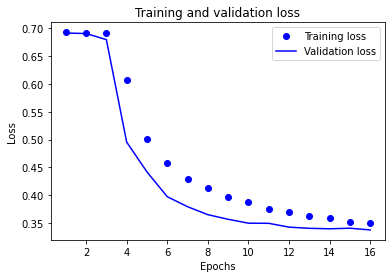

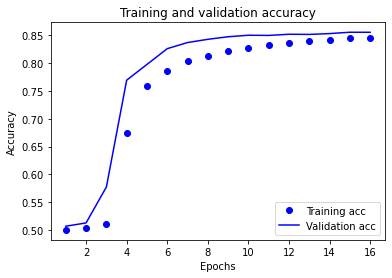

In [78]:
# model 3 viz
history_dict = history_w2v.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# accuracy graph
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

위의 세 모델(단일 lstm, 다층 lstm, cnn) 모두 epoch 1부터 높은 validation accuracy를 보였으나 loss가 매우 높고 과소적합이 나타났던 반면, 한국어 w2v 임베딩을 활용한 결과 0.85가 넘는 accuracy를 보였으며, loss와 accuracy 측면에서도 과적합 되는 일 없이 두 그래프간 격차가 크지 않은 것을 확인할 수 있다.